# 1. Business understanding

## 1.1 Problem Identification and Objective
Sports analytics has long been an important field of science. It has key relevance in various industries. For example bookmakers rely heavily on accurately predicting applications as their models can  affect their productivity by  minimising risk (and of course by maximising income).
The objective is to evaluate some machine learning and classification techniques and predict football results.

# 2. Data understanding

## 2.1 Import libraries

In [340]:
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz

#for visualising decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#for cross validation
from sklearn.cross_validation import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score

#for Naive Bayes
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

## 2.2 Setup helper functions


In [341]:
def plthistogram(dataset, feature1, feature2, label_f1, label_f2, xlabel, ylabel, title):
    plt.hist(dataset[[feature1, feature2]].values,label = [label_f1, label_f2],normed=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_correlation(dataset, feature1, feature1n1, label_f1, label_f2, feature2, feature2n2, xlabel, ylabel,title):
    plt.bar(dataset[feature1], dataset[feature1n1], label = label_f1)
    plt.bar(dataset[feature2], dataset[feature2n2], label = label_f2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()
    
def cross_validate(dataset,predictors, target, dtclf):
    X=dataset[predictors]
    Y=dataset[target]
    dtclf.fit(X,Y)
    dtclf = DecisionTreeClassifier(criterion='entropy',max_depth=5,
    min_samples_split=20, random_state=99)

    crossvalidation = KFold(n=X.shape[0], n_folds=10, shuffle=True,
    random_state=1)    
    score = np.mean(cross_val_score(dtclf, X, Y, scoring='accuracy',
    cv=crossvalidation, n_jobs=1))
    return score

def classify_with_NaiveBayes(clf, features, target, train, test):
    clf.fit(train[features].values, train[target])
    predCLF = clf.predict(test[features])
    return 100 * (1-(test[target] != predCLF).sum() / test.shape[0])

def create_confusion_matrix(clf, features, target, train, test):
    clf.fit(train[features].values, train[target])
    predCLF = clf.predict(test[features])
    return pd.crosstab(test[target], predCLF, rownames=['Actual'], colnames=['Predictions' ])


## 2.3 Load data

In [342]:
data = pd.read_csv('D1.csv')
data.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAvU2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,D1,26/08/16,Bayern Munich,Werder Bremen,6,0,H,2,0,H,...,3.94,31,-2.50,1.85,1.79,3.79,3.53,1.08,14.50,34.00
1,D1,27/08/16,Augsburg,Wolfsburg,0,2,A,0,1,A,...,1.82,29,0.00,2.04,1.98,1.91,1.85,2.99,3.39,2.56
2,D1,27/08/16,Dortmund,Mainz,2,1,H,1,0,H,...,2.32,32,-1.50,2.08,1.99,1.90,1.84,1.29,6.55,10.80
3,D1,27/08/16,Ein Frankfurt,Schalke 04,1,0,H,1,0,H,...,1.98,30,0.25,2.01,1.95,1.95,1.90,3.30,3.53,2.31
4,D1,27/08/16,FC Koln,Darmstadt,2,0,H,1,0,H,...,1.64,30,-1.00,2.60,2.46,1.61,1.56,1.54,4.33,7.12


### Variable description
FTHG and HG = Full Time Home Team Goals<br/>
FTAG and AG = Full Time Away Team Goals<br/>
FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)<br/>
HTHG = Half Time Home Team Goals<br/>
HTAG = Half Time Away Team Goals<br/>
HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)<br/><br/>

Match Statistics (where available)<br/>
Attendance = Crowd Attendance<br/>
Referee = Match Referee<br/>
HS = Home Team Shots<br/>
AS = Away Team Shots<br/>
HST = Home Team Shots on Target<br/>
AST = Away Team Shots on Target<br/>
HHW = Home Team Hit Woodwork<br/>
AHW = Away Team Hit Woodwork<br/>
HC = Home Team Corners<br/>
AC = Away Team Corners<br/>
HF = Home Team Fouls Committed<br/>
AF = Away Team Fouls Committed<br/>
HFKC = Home Team Free Kicks Conceded<br/>
AFKC = Away Team Free Kicks Conceded<br/>
HO = Home Team Offsides<br/>
AO = Away Team Offsides<br/>
HY = Home Team Yellow Cards<br/>
AY = Away Team Yellow Cards<br/>
HR = Home Team Red Cards<br/>
AR = Away Team Red Cards<br/>
HBP = Home Team Bookings Points (10 = yellow, 25 = red)<br/>
ABP = Away Team Bookings Points (10 = yellow, 25 = red)<br/>
<br/><br/>
Please note that columns such as B365, BSH, GBH, IWH, LBD, etc. are icluded in the full dataset presented above. They correspond to the odds of bookmakers and will shortly be removed due to irrelevance in my prediction.


## 2.4 Statistical Analytics

### 2.4.1 Explore overall data

In [343]:
matches = len(data)
print('All matches in 2016-17 season in the Bundesliga: ', matches)

total_goals = sum(data['FTHG']) + sum(data['FTAG'])
avg_goals = Decimal(total_goals / matches)
print ('Average goals per games: ',round(avg_goals,2))

num_goals_scored_home = sum(data['FTHG'])
print ('Number of goals scored home: ', num_goals_scored_home)
avg_goals_home = Decimal(num_goals_scored_home / matches)
print ('Average goals scored home / game: ',round(avg_goals_home,2))   
                            
num_goals_scored_away = sum(data['FTAG'])
print ('Number of goals scored away: ',num_goals_scored_away)
avg_goals_away = Decimal(num_goals_scored_away / matches)
print ('Average goals scored away / game: ',round(avg_goals_away,2))   
                            
num_home_wins = data[data['FTR'] == 'H']
print ('Number of home wins: ',len(num_home_wins))
avg_home_wins = len(num_home_wins) / matches * 100
print ('Percentage of home wins: ',round(avg_home_wins,2),'%')

num_away_wins = data[data['FTR'] == 'A']
print ('Number of away wins: ',len(num_away_wins))
avg_away_wins = len(num_away_wins) / matches * 100
print ('Percentage of home wins: ',round(avg_away_wins,2),'%')
teams = data['HomeTeam'].unique().tolist()  


All matches in 2016-17 season in the Bundesliga:  306
Average goals per games:  2.87
Number of goals scored home:  507
Average goals scored home / game:  1.66
Number of goals scored away:  370
Average goals scored away / game:  1.21
Number of home wins:  150
Percentage of home wins:  49.02 %
Number of away wins:  82
Percentage of home wins:  26.8 %


In [344]:
##compare shots accuracy when playing home vs playing away. Is  there a difference?
#answer: the home team has to create less chances to score so they're more accurate
total_away_shots_on_target = sum(data['AST'])
total_home_shots_on_target = sum(data['HST'])

away_score_accuracy = round(total_away_shots_on_target / num_goals_scored_away,2)
print ('Away scoring accuracy: ',away_score_accuracy)
home_score_accuracy = round(total_home_shots_on_target / num_goals_scored_home,2)
print ('Home scoring accuracy: ',home_score_accuracy)


Away scoring accuracy:  3.34
Home scoring accuracy:  2.9


### 2.4.2 Explore individual team data

In [345]:
def getTeamData(team):
    home_matches = data[data['HomeTeam']==team]
    total_home_goals_for_team = home_matches['FTHG'].sum()
    avg_home_goals_for_team = total_home_goals_for_team / len(home_matches)
    
    away_matches = data[data['AwayTeam']==team]
    total_away_goals_for_team = away_matches['FTAG'].sum()
    avg_away_goals_for_team = total_away_goals_for_team / len(away_matches)
    
    total_home_shots_on_target = home_matches['HST'].sum()
    avg_home_shots_on_target = total_home_shots_on_target / len(home_matches)
    
    home_accuracy_percentage_for_team = round((avg_home_goals_for_team /avg_home_shots_on_target)*100,2)
    
    total_away_shots_on_target = away_matches['AST'].sum()
    avg_away_shots_on_target = total_away_shots_on_target / len(away_matches)
    
    away_accuracy_percentage_for_team = round((avg_away_goals_for_team /avg_away_shots_on_target)*100,2) 
    avg_acc_of_team = round((home_accuracy_percentage_for_team + away_accuracy_percentage_for_team) / 2,2)
    
    return [team, avg_home_goals_for_team, avg_away_goals_for_team, avg_home_shots_on_target, avg_away_shots_on_target, 
            home_accuracy_percentage_for_team, away_accuracy_percentage_for_team, avg_acc_of_team]

all_team_stats = [] 
accuracy_home = []
accuracy_away = []
accuracy_avg = []

for team in teams:
    teams_data = getTeamData(team)
    
    all_team_stats.append(teams_data)
    
    if teams_data[1] > 2.5:
        print ('Team to score over 2.5 goals at home on average: ',team, 'with Average: ',round(teams_data[1],2))
    if teams_data[1] < 1:
        print ('Team to score less than 1 goal at home on average: ',team, 'with Average: ',round(teams_data[1],2))
        
    if teams_data[2] > 1.5:
        print ('Team to score over 1.5 goals away on average: ',team, 'with Average: ',round(teams_data[2],2)) 

        
    accuracy_away.append(float(teams_data[6])) 
    accuracy_home.append(float(teams_data[5])) 
    accuracy_avg.append(float(teams_data[7])) 
    
    if teams_data[6] == max(accuracy_away):
          best_team_away = teams_data[0]
    if teams_data[5] == max(accuracy_home):
         best_team_home = teams_data[0]
            
    if teams_data[6] == min(accuracy_away):
          worst_team_away = teams_data[0]
    if teams_data[5] == min(accuracy_home):
         worst_team_home = teams_data[0]
            
    if teams_data[7] == min(accuracy_avg):
         worst_team_avg = teams_data[0]
    if teams_data[7] == max(accuracy_avg):
         best_team_avg = teams_data[0]
        

    
print ('\nMost efficient team away: ',best_team_away, 'with Average: ',round(max(accuracy_away),2),'%')  
print ('Most efficient team home: ',best_team_home, 'with Average: ',round(max(accuracy_home),2),'%')  
print ('\nLeast efficient team away: ',worst_team_away, 'with Average: ',round(min(accuracy_away),2),'%')  
print ('Least efficient team home: ',worst_team_home, 'with Average: ',round(min(accuracy_home),2),'%')  
print ('\nLeast efficient team in average: ',worst_team_avg, 'with Average: ',round(min(accuracy_avg),2),'%')  
print ('Most efficient team in average: ',best_team_avg, 'with Average: ',round(max(accuracy_avg),2),'%') 

#test
#print(getTeamData('FC Koln'))
#print(getTeamData('Werder Bremen'))
#print(getTeamData('Bayern Munchen'))


Team to score over 2.5 goals at home on average:  Bayern Munich with Average:  3.24
Team to score over 1.5 goals away on average:  Bayern Munich with Average:  2.0
Team to score over 1.5 goals away on average:  Dortmund with Average:  1.82
Team to score over 1.5 goals away on average:  Hoffenheim with Average:  1.71
Team to score over 1.5 goals away on average:  Leverkusen with Average:  1.53
Team to score over 1.5 goals away on average:  RB Leipzig with Average:  1.82
Team to score less than 1 goal at home on average:  Wolfsburg with Average:  0.88
Team to score over 1.5 goals away on average:  Werder Bremen with Average:  1.94

Most efficient team away:  Werder Bremen with Average:  44.59 %
Most efficient team home:  FC Koln with Average:  43.28 %

Least efficient team away:  Ingolstadt with Average:  19.74 %
Least efficient team home:  Wolfsburg with Average:  21.13 %

Least efficient team in average:  Ingolstadt with Average:  22.08 %
Most efficient team in average:  FC Koln with A

# 3. Data Pre-processing

## 3.1 Dealing with missing values
As a first attempt to predict scores, a decision tree will be implemented. While this classifier is able to handle numerical and categorical data respectively, it does not support missing values. Further on, however, categorical values do get converted into numerical values, because the initial design included the implementation of an SVM.   

### 3.1.1 Identify missing values

In [346]:
#check if there's any missing value
print ('Rows with missing values: ',data.isnull().values.any().sum())
missing_value_rows = data[data.isnull().any(1)]
missing_value_rows

Rows with missing values:  1


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAvU2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
29,D1,20/09/16,Ingolstadt,Ein Frankfurt,0,2,A,0,1,A,...,1.65,33,-0.25,1.95,1.88,2.03,1.97,2.0,3.49,4.28


### 3.1.2 Prepare dataset with substituting NaNs

In [347]:
#fill in the missing values with 

#missing_value_rows.fillna(data['WHH'].mean)
values = {'WHH': data['WHH'].mean, 'WHD': data['WHD'].mean, 'WHA': data['WHA'].mean}
data2 = data.fillna(value = values)
print ('Rows with missing values: ',data2.isnull().values.any().sum())

Rows with missing values:  0


## 3.2 Prepare dataset with no betting odds

In [348]:
#delete columns with betting data
wanted_columns = ['Div','Date', 'HomeTeam','AwayTeam', 'FTHG', 'FTAG','FTR','HTHG', 'HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR' ]
column_list = data.columns.values.tolist()
sublist = [x for x in column_list if x in wanted_columns]
mydata = data[sublist]
mydata.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,D1,26/08/16,Bayern Munich,Werder Bremen,6,0,H,2,0,H,...,14,2,7,8,8,1,0,1,0,0
1,D1,27/08/16,Augsburg,Wolfsburg,0,2,A,0,1,A,...,2,6,15,17,2,3,1,2,0,0
2,D1,27/08/16,Dortmund,Mainz,2,1,H,1,0,H,...,8,4,3,20,7,2,0,3,0,0
3,D1,27/08/16,Ein Frankfurt,Schalke 04,1,0,H,1,0,H,...,4,3,11,15,7,5,2,2,1,0
4,D1,27/08/16,FC Koln,Darmstadt,2,0,H,1,0,H,...,8,3,11,15,6,5,3,3,0,0


#### Key information about the variables

In [349]:
mydata.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000
mean,1.656863,1.209150,0.738562,0.506536,13.493464,11.401961,4.803922,4.039216,13.787582,14.830065,4.924837,4.199346,1.696078,2.039216,0.091503,0.091503
std,1.321909,1.231572,0.815998,0.725387,4.995896,4.721614,2.549340,2.368876,4.318922,4.193345,2.804722,2.409571,1.226397,1.261705,0.299934,0.288796
min,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,11.000000,12.000000,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,13.000000,11.000000,5.000000,4.000000,13.500000,15.000000,5.000000,4.000000,2.000000,2.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000,16.000000,14.000000,6.000000,5.000000,17.000000,17.000000,7.000000,6.000000,2.000000,3.000000,0.000000,0.000000
max,8.000000,6.000000,4.000000,3.000000,33.000000,28.000000,14.000000,11.000000,28.000000,28.000000,15.000000,14.000000,6.000000,6.000000,2.000000,1.000000


In [350]:
#see goals distribution by teams
grouped = mydata.groupby(['HomeTeam', 'FTR'])
grouped.aggregate({'FTHG':np.mean, 'FTAG':np.mean}).head()

FTHG      FTAG
HomeTeam      FTR                    
Augsburg      A    0.833333  2.666667
              D    1.000000  1.000000
              H    2.200000  0.600000
Bayern Munich D    1.250000  1.250000
              H    3.846154  0.307692

# 4. Visualisation

#### Plotting goals scored home/away
the home team always seems to score more than the away team

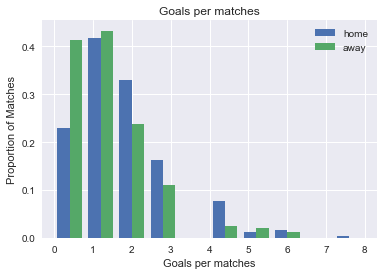

In [351]:
plthistogram(mydata, 'FTHG', 'FTAG', 'home', 'away', 'Goals per matches', 'Proportion of Matches', 'Goals per matches')


## Plotting correlation between Home advantage and Away Disadvantage based on accuracy of shooting and scoring

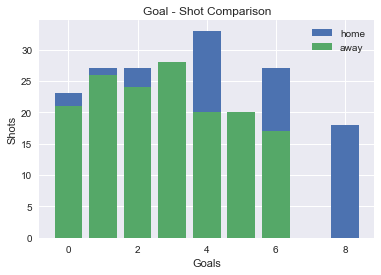

In [352]:
plot_correlation(mydata, 'FTHG', 'HS', 'home','away', 'FTAG', 'AS', 'Goals', 'Shots','Goal - Shot Comparison')

# 5. Modeling

## 5.1 Model 1 - Decision Tree

### 5.1.1 Feature engineering - create new columns with category replaced numeric values

In [353]:

lb_HomeTeam = LabelEncoder()
#mydata['HomeTeam_nums'] = lb_HomeTeam.fit_transform(mydata['HomeTeam'])

lb_AwayTeam = LabelEncoder()
mydata.head()
exist = False

if (('AwayTeam_numbers' not in mydata.columns) and ('HomeTeam_numbers' not in mydata.columns)):
    exist = True
else:
    del mydata['AwayTeam_numbers']
    del mydata['HomeTeam_numbers']

if exist:
    mydata.insert(22, 'AwayTeam_numbers', lb_HomeTeam.fit_transform(mydata['AwayTeam']))
    mydata.insert(23, 'HomeTeam_numbers', lb_HomeTeam.fit_transform(mydata['HomeTeam']))

if (('AwayTeam_numbers' not in data2.columns) and ('HomeTeam_numbers' not in data2.columns)):
    exist = True
else:
    del data2['AwayTeam_numbers']
    del data2['HomeTeam_numbers']


# add odds back
if exist:
    data2.insert(22, 'AwayTeam_numbers', lb_HomeTeam.fit_transform(mydata['AwayTeam']))
    data2.insert(23, 'HomeTeam_numbers', lb_HomeTeam.fit_transform(mydata['HomeTeam']))

### 5.1.2 Specify target and predictors

In [354]:
all_col_names = mydata.columns.values.tolist()
predictor_names = all_col_names[10:24]

target = all_col_names[6]
#test
print (all_col_names[23])

HomeTeam_numbers


### 5.1.3 specify target and predictions for data2 (filled NaNs + betting odds)

In [355]:
all_col_names2 = data2.columns.values.tolist()
halftimegoals_predictors_names = all_col_names2[7:9]
predictor_names2 = all_col_names2[10:39] + all_col_names2[43:64] + halftimegoals_predictors_names

#test
print (all_col_names2[9])

HTR


In [356]:
secondhalf_predictor_names = predictor_names + halftimegoals_predictors_names

### 5.1.4 Split data into training and test sets

In [357]:
mydata['is_train'] = np.random.uniform(0,1, len(data)) <= .75
train, test = mydata[mydata['is_train']==True], mydata[mydata['is_train']==False]

C:\Users\BangoCs\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### 5.1.5 Get predicitons for stats

In [358]:
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=10, random_state=99)
dt.fit(train[predictor_names], train[target])
preds = dt.predict(test[predictor_names])
pd.crosstab(test['FTR'], preds, rownames=['Actual'], colnames=['Predictions' ])

Predictions,A,D,H
Actual,,,
A,10,7,5
D,4,3,6
H,11,8,22


### 5.1.6 Get predicitons for dt_ht (stats + half time results)

In [359]:
dt_ht = DecisionTreeClassifier(criterion='entropy', min_samples_split=10, random_state=99)
dt_ht.fit(train[secondhalf_predictor_names], train[target])
preds = dt_ht.predict(test[secondhalf_predictor_names])
pd.crosstab(test['FTR'], preds, rownames=['Actual'], colnames=['Predictions' ])

Predictions,A,D,H
Actual,,,
A,9,7,6
D,2,4,7
H,6,15,20


### 5.1.7 Get predictions for dt2 (stats + half time + betting odds)

In [360]:
#split data2
data2['is_train'] = np.random.uniform(0,1, len(data)) <= .75
train, test = data2[data2['is_train']==True], data2[data2['is_train']==False]

dt2 = DecisionTreeClassifier(criterion='entropy', min_samples_split=10, random_state=99)
dt2.fit(train[predictor_names2], train[target])
preds = dt2.predict(test[predictor_names2])
pd.crosstab(test['FTR'], preds, rownames=['Actual'], colnames=['Predictions' ])

Predictions,A,D,H
Actual,,,
A,9,3,5
D,2,4,8
H,3,7,29


### 5.1.8 Visualising the tree

In [361]:
#stats
export_graphviz(dt, 'dt.dot', feature_names=predictor_names)

#stats + half time
export_graphviz(dt_ht, 'dt_ht.dot', feature_names=secondhalf_predictor_names)

#stats + half time + betting odds
export_graphviz(dt2, 'dt2.dot', feature_names=predictor_names2)

#### tree result

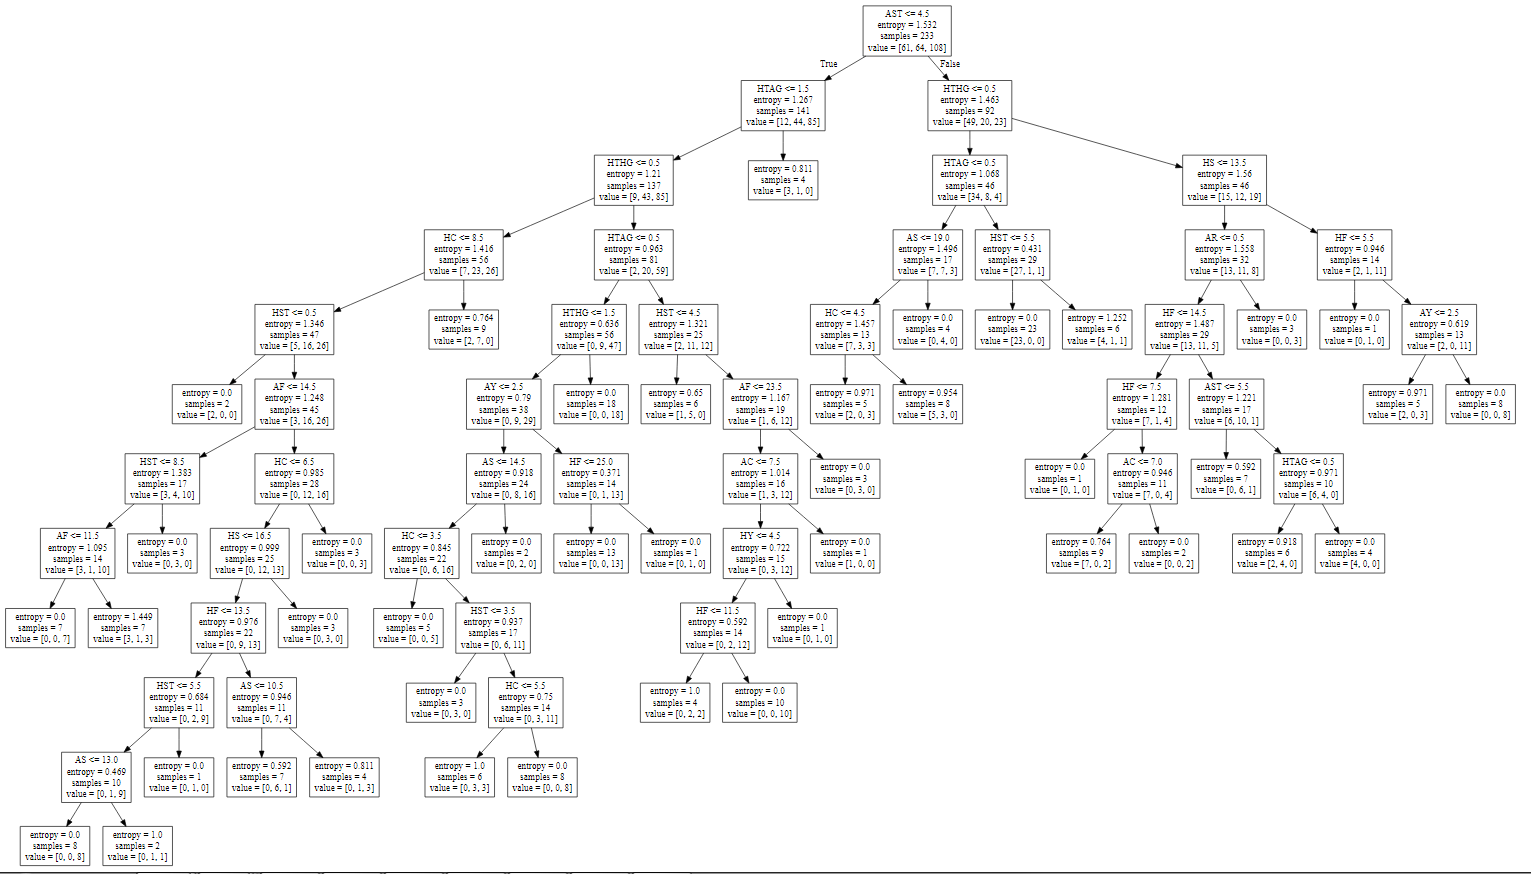

In [235]:
import IPython
IPython.display.Image("treeresult.png")

### 5.1.9  Cross validate the dataset

In [362]:
#stats + half time
score = cross_validate(mydata,secondhalf_predictor_names, target, dt_ht)
print('Accuracy score of the model with Half Time Results but NO betting data: ',score)

Accuracy score of the model with Half Time Results but NO betting data:  0.559139784946


In [363]:
#stats 
score = cross_validate(mydata,predictor_names, target, dt)
print('Accuracy score of the model with NO Half Time Results and NO betting data: ',score)

Accuracy score of the model with NO Half Time Results and NO betting data:  0.568924731183


In [364]:
#stats + half time + betting odds
score = cross_validate(data2,predictor_names2, target, dt2)
print('Accuracy score of the model with stats, Half Time Results AND betting data: ',score)

Accuracy score of the model with stats, Half Time Results AND betting data:  0.562365591398


## 5.2 Model 2 - Naive Bayes - Gaussian, Multinomial, Bernoulli

In [365]:
gnb =  GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

features = ['HomeTeam_numbers','AwayTeam_numbers', 'FTHG','FTAG', 'HTAG', 'HTHG','HS', 'AS','HST','AST', 'HC','AC', 'HF','AF', 'HY','AY', 'HR','AR']
target = 'FTR'
print('Gaussian Naive Bayes Performance: ',classify_with_NaiveBayes(gnb, features, target, train, test))
print('Multinomial Naive Bayes Performance: ',classify_with_NaiveBayes(mnb, features, target, train, test))
print('Bernoulli Naive Bayes Performance: ',classify_with_NaiveBayes(bnb, features, target, train, test))


Gaussian Naive Bayes Performance:  75.7142857143
Multinomial Naive Bayes Performance:  71.4285714286
Bernoulli Naive Bayes Performance:  72.8571428571


In [366]:
#Gaussian
create_confusion_matrix(gnb, features, target, train, test)

Predictions,A,D,H
Actual,,,
A,15,2,0
D,3,6,5
H,0,7,32


In [367]:
#Multinomial
create_confusion_matrix(mnb, features, target, train, test)

Predictions,A,D,H
Actual,,,
A,14,3,0
D,5,2,7
H,1,4,34


In [368]:
#Beroulli
create_confusion_matrix(bnb, features, target, train, test)

Predictions,A,D,H
Actual,,,
A,10,0,7
D,2,4,8
H,2,0,37


In [369]:
mean_ftr_home_win =np.mean(train['FTR']=='H')
mean_ftr_away_win =np.mean(train['FTR']=='A')
mean_ftr_draw =np.mean(train['FTR']=='D')
print('Probability of Home win',round(100 * mean_ftr_home_win,2),'%')
print('Probability of Away win',round(100 * mean_ftr_away_win,2),'%')
print('Probability of Draw',round(100 * mean_ftr_draw,2),'%')

Probability of Home win 47.03 %
Probability of Away win 27.54 %
Probability of Draw 25.42 %


# pip installs

In [370]:
#import sys
#!{sys.executable} -m pip install graphviz 

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# References


In [103]:
#Visualising decision tree:
#source: http://davidasboth.com/2016/11/28/visualising-decision-trees-in-python/
#name: David Asboth
#date: 29/04/2018
#modified: no

#Naive Bayes:
#source:https://blog.sicara.com/naive-bayes-classifier-sklearn-python-example-tips-42d100429e44
#name: Martin Muller
#date: 01/05/2018
#modified: yes, changed features + added Multinomial and Bernoulli NB 

#for feature extraction:
#source: https://mariamsulakian.com/2018/02/01/machine-learning-predicting-the-2018-epl-matches/
#name: Mariam Sulakian
#date: 28/04/2018
#modified: yes, used part of her getAnnualTeamData(), added more features 